In [270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import levenberg_marquardt
from matplotlib.pyplot import figure
import heston
from importlib import reload
reload(heston)
from heston import calibrate_heston, get_tick
import datetime
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [6]:
# h5 = h5py.File('../datasets/eth-20230127.h5','r')
raw = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")

In [278]:
def process_data(data):
    # only options
    df = data.copy()
    df = df[(df["instrument"].str.endswith("C")) | (df["instrument"].str.endswith("P"))].sort_values("dt")
    df["type"] = np.where(df["instrument"].str.endswith("C"), "call", "put")
    
    perpetuals = data[data["instrument"].str.endswith("PERPETUAL")][["dt", "price"]].copy()
    perpetuals = perpetuals.rename(columns = {"price": "underlying_price"}).sort_values("dt")
    
    def get_strike(x):
        return int(x.split("-")[2])
    
    def get_expiration(x):
        return x.split("-")[1]
    

    df["strike_price"] = df["instrument"].apply(get_strike)
    df["expiration"] = df["instrument"].apply(get_expiration)
    
    def unix_time_millis(dt):
        epoch = datetime.datetime.utcfromtimestamp(0)
        return int((dt - epoch).total_seconds() * 1000_000)
    
    def get_normal_date(s):
        """Function to convert date to find years to maturity"""
        monthToNum = {
            "JAN": 1,
            "FEB": 2,
            "MAR": 3,
            "APR": 4,
            "MAY": 5,
            "JUN": 6,
            "JUL": 7,
            "AUG": 8,
            "SEP": 9,
            "OCT": 10,
            "NOV": 11,
            "DEC": 12,
        }

        full_date = s.split("-")[1]
        try:
            day = int(full_date[:2])
            month = monthToNum[full_date[2:5]]
        except:
            day = int(full_date[:1])
            month = monthToNum[full_date[1:4]]
        
        year = int("20" + full_date[-2:])
        exp_date = datetime.datetime(year, month, day)
        return unix_time_millis(exp_date)
    
    df["dt"] = pd.to_datetime(df["dt"])
    perpetuals["dt"] = pd.to_datetime(perpetuals["dt"])
    
    df = pd.merge_asof(df, perpetuals, on="dt",
                       tolerance=pd.Timedelta('7 minutes'),
                       direction='nearest',)
    
    df["timestamp"] = df["dt"].apply(unix_time_millis)
    df["expiration"] = df["instrument"].apply(get_normal_date)
    df = df.rename(columns = {"price": "mark_price"})
    
    
    return df

In [279]:
%%time
df = process_data(raw)
df
# df = df[df["dt"]>='2023-01-09 00:00:00.000000']

CPU times: user 38 s, sys: 32.8 s, total: 1min 10s
Wall time: 4min 16s


,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2200-C,call,2200,1669334400000000,1133.9,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2300-C,call,2300,1669334400000000,1133.9,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.9,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.9,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.9,1669036104511000
...,...,...,...,...,...,...,...,...
5136055,2023-01-27 07:45:19.053,0.0480,ETH-27JAN23-1650-P,put,1650,1674777600000000,1581.7,1674805519053000
5136056,2023-01-27 07:45:19.053,0.0160,ETH-27JAN23-1000-P,put,1000,1674777600000000,1581.7,1674805519053000
5136057,2023-01-27 07:45:19.054,0.0005,ETH-27JAN23-1650-C,call,1650,1674777600000000,1581.7,1674805519054000
5136058,2023-01-27 07:45:19.055,0.0005,ETH-27JAN23-1400-P,put,1400,1674777600000000,1581.7,1674805519055000


In [293]:
# calibrate base
number_of_dots = 200
names = ["kappa", "nu_bar", "sigma", "rho", "nu0"]
kappas, nu_bars, sigmas, rhos, nu0s, errors = [], [], [], [], [], []
a = np.float64(3.0)  # kappa                     |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(0.1)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(0.25)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(0.01)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.08) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])
print("Optimize first params with random start once")
calibrated_params, first_error = calibrate_heston(df = df, start_params = start_params)
# print(calibrated_params)

# Get ticks with similar distnce from available data
timestamps = np.linspace(df.timestamp.min(), df.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    try:
        calibrated_params, error = calibrate_heston(df = df, start_params = calibrated_params, timestamp = timestamp)
#         print("Optimized parameters:", *zip(names, (calibrated_params).round(5)), sep="\n")
        kappas.append(calibrated_params[0])
        nu_bars.append(calibrated_params[1])
        sigmas.append(calibrated_params[2])
        rhos.append(calibrated_params[3])
        nu0s.append(calibrated_params[4])
        errors.append(error)
    except:
        # if could not calibrate, start next calibration with random params
        calibrated_params = start_params
        print(f"Could not calibrate on {timestamp}")
    


Optimize first params with random start once


  0%|          | 0/200 [00:00<?, ?it/s]

Could not calibrate on 1669355016872784.0


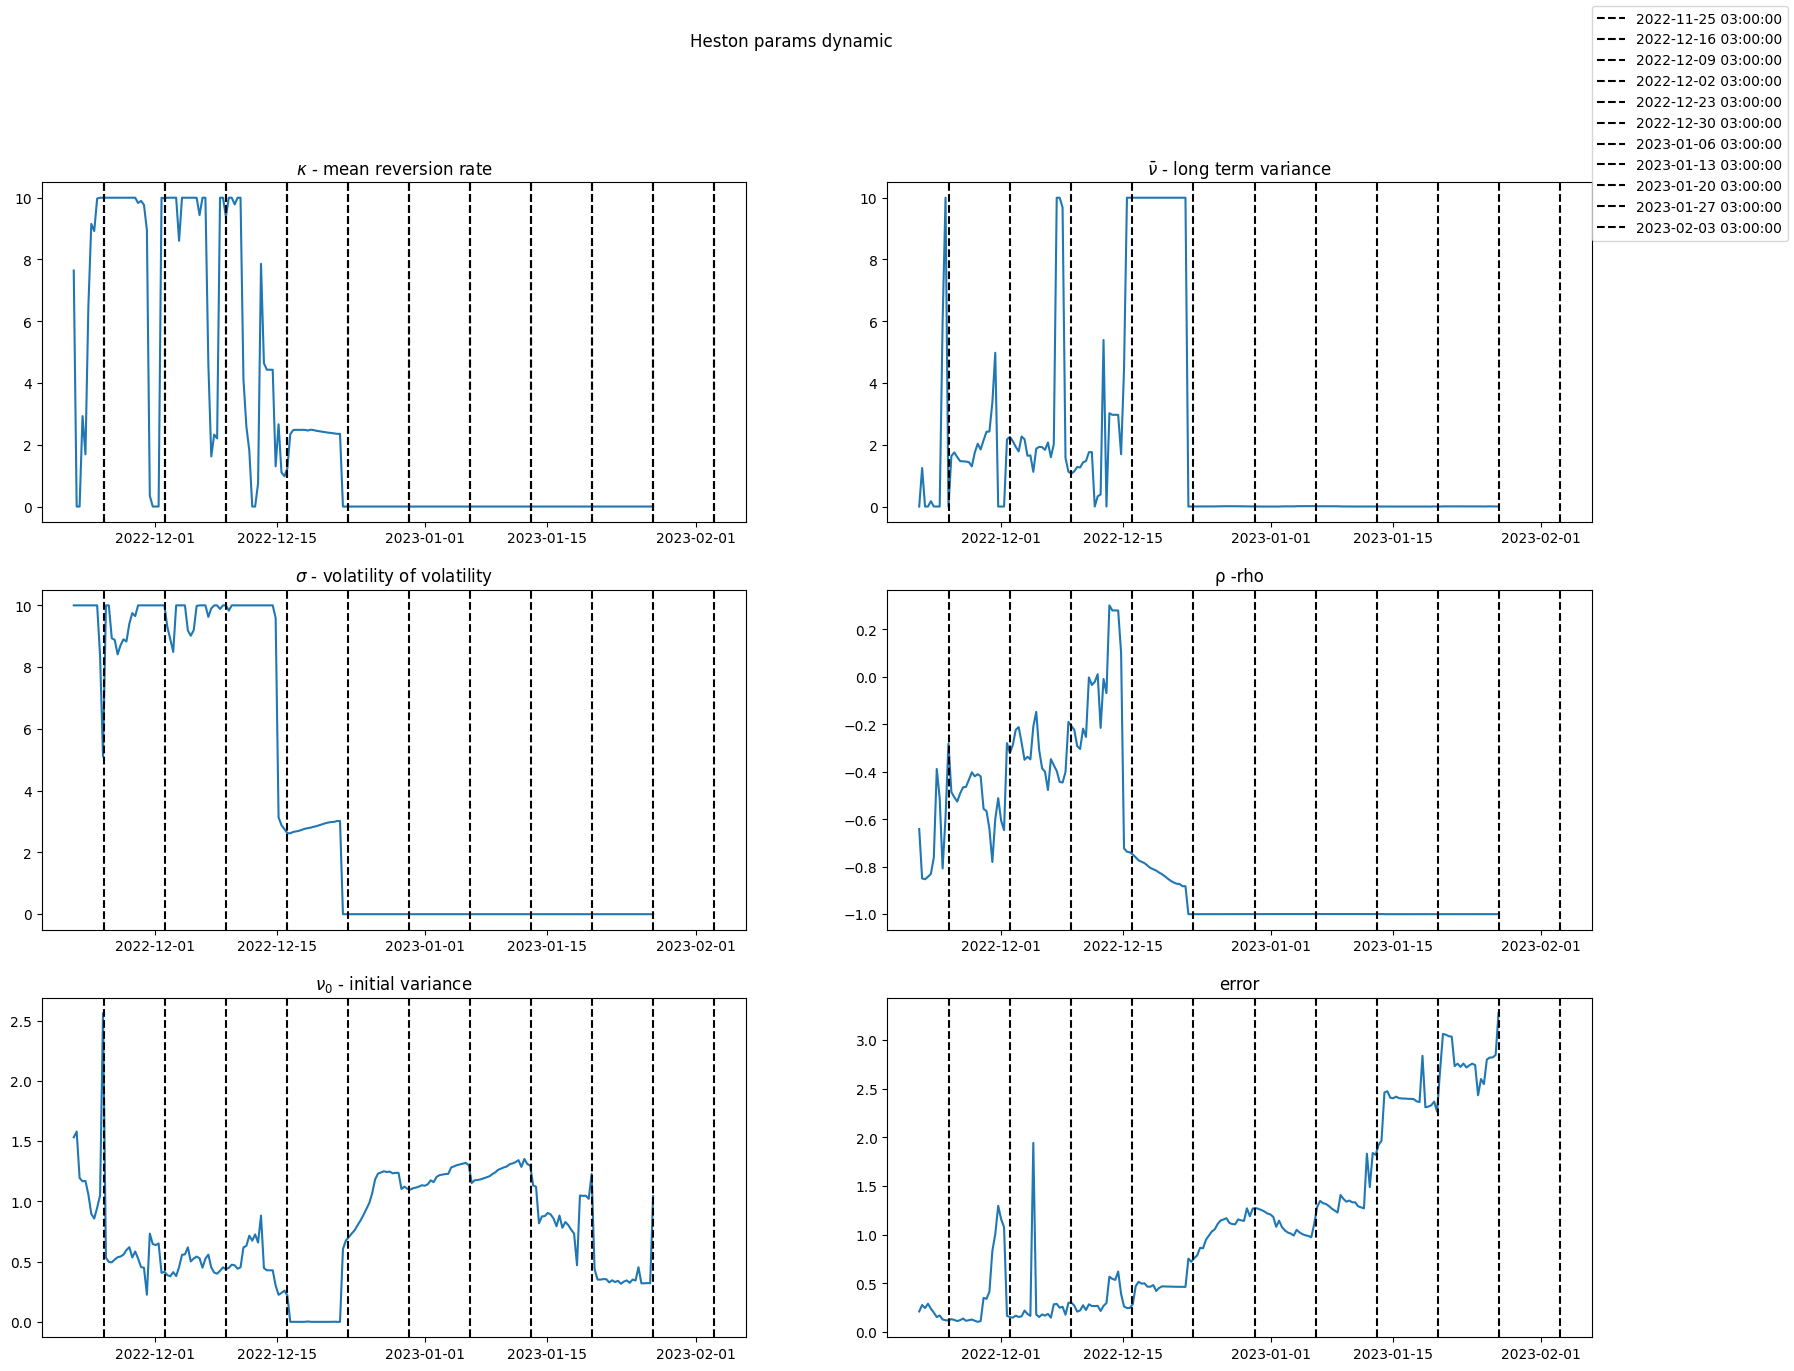

In [296]:
timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps[:-1]]
expirarions = df.expiration.unique()
expirarions = [datetime.datetime.fromtimestamp(ms/1000000.0) for ms in expirarions]
# expirarions
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))


axs[0, 0].plot(timestamps_hm, kappas)
axs[0, 0].set_title(r"$\kappa$ - mean reversion rate")

axs[0, 1].plot(timestamps_hm, nu_bars)
axs[0, 1].set_title(r"$\bar{\nu}$ - long term variance")

axs[1, 0].plot(timestamps_hm, sigmas)
axs[1, 0].set_title(r"$\sigma$ - volatility of volatility")

axs[1, 1].plot(timestamps_hm, rhos)
axs[1, 1].set_title("ρ -rho")

axs[2, 0].plot(timestamps_hm, nu0s)
axs[2, 0].set_title(r"$\nu_0$ - initial variance")

axs[2, 1].plot(timestamps_hm, errors)
axs[2, 1].set_title("error")



for i in range(3):
    for j in range(2):
        for exp in expirarions:
#             axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
            axs[i, j].axvline(x=exp, color = "black", linestyle  = "--")
            if i == j == 0:
                axs[i, j].axvline(x=exp, color = "black", linestyle  = "--", label = exp)


plt.figlegend() 
fig.suptitle("Heston params dynamic")

plt.show()